In [22]:
#utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import pprint as pp


#text processing & sentiment analysis
import re
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

#from afinn import Afinn
import unicodedata as ud
import camel_tools as ct
from nltk.stem.isri import ISRIStemmer
from ar_wordcloud import ArabicWordCloud
import time

#model
from textblob import TextBlob

from sklearn.metrics import classification_report, accuracy_score
from camel_tools.dialectid           import DialectIdentifier
from camel_tools.utils.normalize     import normalize_alef_maksura_ar
from camel_tools.utils.normalize     import normalize_alef_ar
from camel_tools.utils.normalize     import normalize_teh_marbuta_ar
from camel_tools.utils.normalize     import normalize_unicode
from camel_tools.utils.dediac        import dediac_ar
from camel_tools.morphology.database import MorphologyDB
from camel_tools.morphology.analyzer import Analyzer
import os
os.environ["CAMELTOOLS_DATA"] = "~/.camel_tools"
from camel_tools.tokenizers.word     import simple_word_tokenize
from camel_tools.disambig.mle        import MLEDisambiguator
from camel_tools.tokenizers.morphological import MorphologicalTokenizer
from camel_tools.sentiment           import SentimentAnalyzer

import arabicstopwords.arabicstopwords as stp

In [2]:

df1_tweets = pd.read_csv('../Vaccine_in_Arab_World/tweet_data_by_day.csv', index_col=0)
df1_tweets = df1_tweets[ df1_tweets['text'].str.startswith('RT') == False ]

#df1_tweets = df1_tweets.head(100)

df2_tweets = pd.read_csv('../Vaccine_in_Arab_World/tweet_data_by_day_post_omicron.csv', index_col=0)
df2_tweets = df2_tweets[ df2_tweets['text'].str.startswith('RT') == False ]

#df2_tweets = df2_tweets.head(100)

In [3]:
df1_tweets.head()
# df1_tweets.sample(1000)

,author_id,created_at,id,text,geo,withheld
0,717625476416684032,2021-07-01 23:59:22+00:00,1410749904410923012,@KUW_Q8Y حليب من الكويت ينباع بمصر يابقره تعال...,NaN,NaN
7,1188149771116126214,2021-07-01 23:58:23+00:00,1410749657609695241,#ماكو_امتحان_الكتروني_ماكو_لقاح #ماكو_امتحان_ا...,NaN,NaN
9,1390018661830758401,2021-07-01 23:58:18+00:00,1410749638500446210,#ماكو_امتحان_الكتروني_ماكو_لقاح\n#ماكو_امتحان_...,NaN,NaN
10,1409967721601699853,2021-07-01 23:57:35+00:00,1410749455859470345,#الالكتروني_حقنا\n#نمتحن_الكتروني_مثل_مدرسنا_ا...,NaN,NaN
12,814024089329352704,2021-07-01 23:57:33+00:00,1410749447479332876,@go2islam كورونا ، لكن أوروبا تعتقد أن لديها ا...,NaN,NaN


In [4]:
df2_tweets.head()
# df2_tweets.sample(1000)

,author_id,created_at,geo,id,text,withheld
0,1.434668e+18,2021-12-01 23:58:44+00:00,NaN,1.466195e+18,@salmaniho والله ما عاد يدرى ياخوك بس شكله بين...,NaN
2,1.228374e+18,2021-12-01 23:57:31+00:00,NaN,1.466195e+18,@300Mimi96 @yemen_alwadiah اصلا جونسون رسمي من...,NaN
3,1.367791e+18,2021-12-01 23:57:12+00:00,NaN,1.466195e+18,إنهاء إجراءات الإفراج الجمركى عن 1.7 مليون جرع...,NaN
4,1.059093e+18,2021-12-01 23:56:44+00:00,NaN,1.466195e+18,#اكتب_اي_شي_تبيه\r\nوش رايكم باللي ماياخذ لقاح...,NaN
5,1.427640e+18,2021-12-01 23:56:08+00:00,NaN,1.466194e+18,@mawla_dr بيجيني متل قبل الكورونا، مع العلم ان...,NaN


In [5]:


# for i in range(0,df1_tweets.size):
#    df1_tweets['text'][i] = normalize_alef_ar(df1_tweets['text'][i]) 

text = 'ﷺ'

sentence = "خبير الأمراض المعدية'أنتوني فاوتشي' يخضع للمساءلة لإتهامه بتمويل تجارب وحشية أجريت على ٤٤ جرو نزعت حبالهم الرومينيجه يحث كيميتش على تلقي لقاح كورونا"


sent_norm = normalize_unicode(sentence)
print(sent_norm)

print(sentence)

# Normalize alef variants to 'ا'
sent_norm = normalize_alef_ar(sentence)
print(sent_norm)

# Normalize alef maksura 'ى' to yeh 'ي'
sent_norm = normalize_alef_maksura_ar(sent_norm)
print(sent_norm)

# Normalize teh marbuta 'ة' to heh 'ه'
sent_norm = normalize_teh_marbuta_ar(sent_norm)
print(sent_norm)

خبير الأمراض المعدية'أنتوني فاوتشي' يخضع للمساءلة لإتهامه بتمويل تجارب وحشية أجريت على ٤٤ جرو نزعت حبالهم الرومينيجه يحث كيميتش على تلقي لقاح كورونا
خبير الأمراض المعدية'أنتوني فاوتشي' يخضع للمساءلة لإتهامه بتمويل تجارب وحشية أجريت على ٤٤ جرو نزعت حبالهم الرومينيجه يحث كيميتش على تلقي لقاح كورونا
خبير الامراض المعدية'انتوني فاوتشي' يخضع للمساءلة لاتهامه بتمويل تجارب وحشية اجريت على ٤٤ جرو نزعت حبالهم الرومينيجه يحث كيميتش على تلقي لقاح كورونا
خبير الامراض المعدية'انتوني فاوتشي' يخضع للمساءلة لاتهامه بتمويل تجارب وحشية اجريت علي ٤٤ جرو نزعت حبالهم الرومينيجه يحث كيميتش علي تلقي لقاح كورونا
خبير الامراض المعديه'انتوني فاوتشي' يخضع للمساءله لاتهامه بتمويل تجارب وحشيه اجريت علي ٤٤ جرو نزعت حبالهم الرومينيجه يحث كيميتش علي تلقي لقاح كورونا


In [6]:

sentence = "هَلْ ذَهَبْتَ إِلَى المَكْتَبَةِ؟"
print(sentence)

sent_dediac = dediac_ar(sentence)
print(sent_dediac)

هَلْ ذَهَبْتَ إِلَى المَكْتَبَةِ؟
هل ذهبت إلى المكتبة؟


In [7]:
# from camel_tools.tokenizers.word import simple_word_tokenize

# sentence = "هَلْ ذَهَبْتَ إِلَى المَكْتَبَةِ؟"
# print(sentence)

# sent_split = simple_word_tokenize(sentence)
# print(sent_split)

In [8]:


# First, we need to load a morphological database.
# Here, we load the default database which is used for analyzing
# Modern Standard Arabic. 
db = MorphologyDB.builtin_db()

analyzer = Analyzer(db)

analyses = analyzer.analyze('موظف')

# for analysis in analyses:
#     print(analysis, '\n')

In [9]:

# The tokenizer expects pre-tokenized text
sentence = simple_word_tokenize("خبير الأمراض المعدية'أنتوني فاوتشي' يخضع للمساءلة لإتهامه بتمويل تجارب وحشية أجريت على ٤٤ جرو نزعت حبالهم الرومينيجه يحث كيميتش على تلقي لقاح كورونا")
print(sentence)

# Load a pretrained disambiguator to use with a tokenizer
mle = MLEDisambiguator.pretrained('calima-msa-r13')

# Without providing additional arguments, the tokenizer will output undiacritized
# morphological tokens for each input word delimited by an underscore.
tokenizer = MorphologicalTokenizer(mle, scheme='d3tok')
tokens = tokenizer.tokenize(sentence)
print(tokens)

# By specifying `split=True`, the morphological tokens are output as seperate
# strings.
tokenizer = MorphologicalTokenizer(mle, scheme='d3tok', split=True)
tokens = tokenizer.tokenize(sentence)
print(tokens)

# We can output diacritized tokens by setting `diac=True`
tokenizer = MorphologicalTokenizer(mle, scheme='d3tok', split=True, diac=True)
tokens = tokenizer.tokenize(sentence)
print(tokens)

['خبير', 'الأمراض', 'المعدية', "'", 'أنتوني', 'فاوتشي', "'", 'يخضع', 'للمساءلة', 'لإتهامه', 'بتمويل', 'تجارب', 'وحشية', 'أجريت', 'على', '٤٤', 'جرو', 'نزعت', 'حبالهم', 'الرومينيجه', 'يحث', 'كيميتش', 'على', 'تلقي', 'لقاح', 'كورونا']
['خبير', 'ال+_أمراض', 'ال+_معدية', "'", 'أنتوني', 'فاوتشي', "'", 'يخضع', 'ل+_ال+_مساءلة', 'ل+_اتهام_+ه', 'ب+_تمويل', 'تجارب', 'وحشية', 'أجريت', 'على', '٤٤', 'جرو', 'نزعت', 'حبال_+هم', 'الرومينيجه', 'يحث', 'كيميتش', 'على', 'تلقي', 'لقاح', 'كوروا_+نا']
['خبير', 'ال+', 'أمراض', 'ال+', 'معدية', "'", 'أنتوني', 'فاوتشي', "'", 'يخضع', 'ل+', 'ال+', 'مساءلة', 'ل+', 'اتهام', '+ه', 'ب+', 'تمويل', 'تجارب', 'وحشية', 'أجريت', 'على', '٤٤', 'جرو', 'نزعت', 'حبال', '+هم', 'الرومينيجه', 'يحث', 'كيميتش', 'على', 'تلقي', 'لقاح', 'كوروا', '+نا']
['خَبِيرٌ', 'ال+', 'أَمْراض', 'ال+', 'مَعْدِيَّةِ', "'", 'أَنْتُونِي', 'فاوتشي', "'", 'يَخْضَع', 'لِ+', 'ال+', 'مُساءَلَةِ', 'لِ+', 'اِتِّهام', '+هُ', 'بِ+', 'تَمْوِيلٍ', 'تَجارِبِ', 'وَحْشِيَّة', 'أُجْرِيَت', 'عَلَى', '٤٤', 'جرو', 'نَزَعْت

In [10]:
with open('ar_stopwords.txt', 'r') as file:
    stopwords = file.read()
#print(stopwords)

In [11]:
from camel_tools.utils.normalize import normalize_unicode
#remove stopwords and all characters that are not arabic letters or # numbers and lemmatize the words
def preprocess_ar(text):
    processedText = []
    
    my_stp = stp.stopwords_list() | { u'كورونا', u'ان' }

    # Cnotreate Lemmatizer and Stemmer.
    st = ISRIStemmer()

    for t in text:
        t = ''.join(c for c in t if ud.category(c) == 'Lo' or ud.category(c) == 'Nd' or c == ' ')
   
        commentwords = ''
        for word in t.split():
            # Checking if the word is a stopword.

            if word not in my_stp:
                if len(word)>1:
                    # Lemmatizing the word.
                    word = st.suf32(word)
                    commentwords += (word+' ')
        processedText.append(normalize_unicode(commentwords))
    
    return processedText

In [12]:
import time
from nltk.stem.isri import ISRIStemmer
import unicodedata as ud

df1_tweets = pd.read_csv('../Vaccine_in_Arab_World/tweet_data_by_day.csv', index_col=0)
print( df1_tweets.size)
df1_tweets = df1_tweets[ df1_tweets['text'].str.startswith('RT') == False ]

#df1_tweets = df1_tweets.head(100)

t = time.time()

# print( df1_tweets.size)
processedtext_ar1 = preprocess_ar( df1_tweets.text )

# my_str=['هذه الجمله فيها كلمة كورو كورو كورو  كورو الان']
#processedtext_ar1 = preprocess_ar(my_str)
# print(processedtext_ar1)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')
# print(processedtext_ar)

311154
Text Preprocessing complete.
Time Taken: 2 seconds


In [13]:
import csv

with open('../Vaccine_in_Arab_World/pre_omicron_df.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(processedtext_ar1)


In [14]:
df2_tweets = pd.read_csv('../Vaccine_in_Arab_World/tweet_data_by_day_post_omicron.csv', index_col=0)
print( df2_tweets.size)
df2_tweets = df2_tweets[ df2_tweets['text'].str.startswith('RT') == False ]

df2_tweets = df2_tweets.head(100)

t = time.time()
processedtext_ar2 = preprocess_ar(df2_tweets.text)

print( df2_tweets.size)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

417444
600
Text Preprocessing complete.
Time Taken: 0 seconds


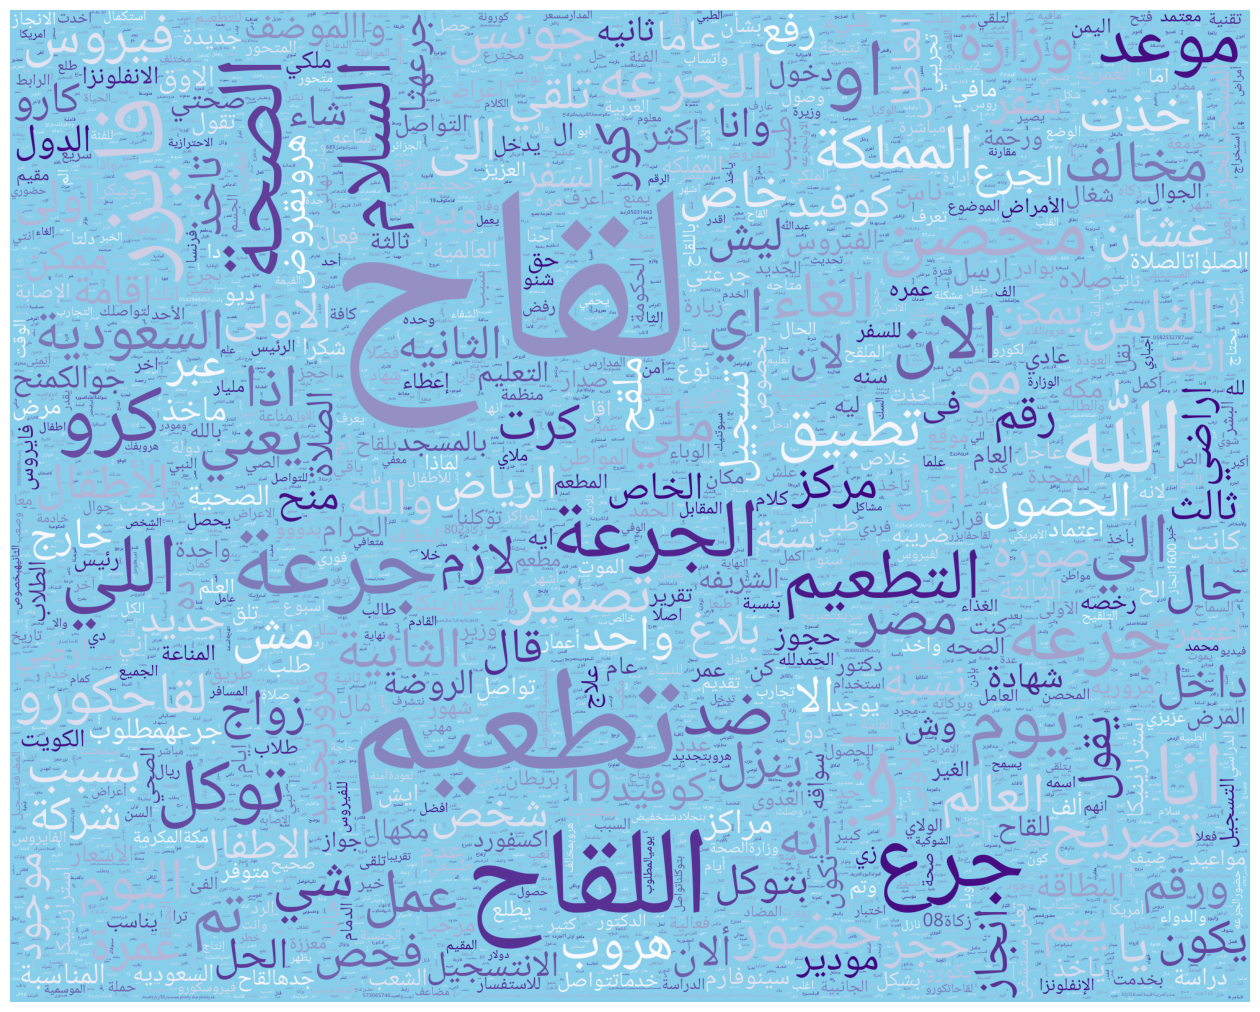

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ar_wordcloud import ArabicWordCloud
stopwords = nltk.corpus.stopwords.words('arabic')
stopwords.extend(['كورو','بدون', 'لكم', 'اللي', 'عشان'])
stopwords.append( stopwords)
awc = ArabicWordCloud(width=2000,height=1600,max_font_size=400,max_words=10000,collocations=False, background_color='skyblue', colormap="Purples")

plt.figure(figsize=(16,16))

wc_ar = awc.from_text(u''.join(processedtext_ar1))
plt.axis("off")
plt.imshow(wc_ar)
plt.savefig("WC1.png")

# awc = ArabicWordCloud(background_color="white")

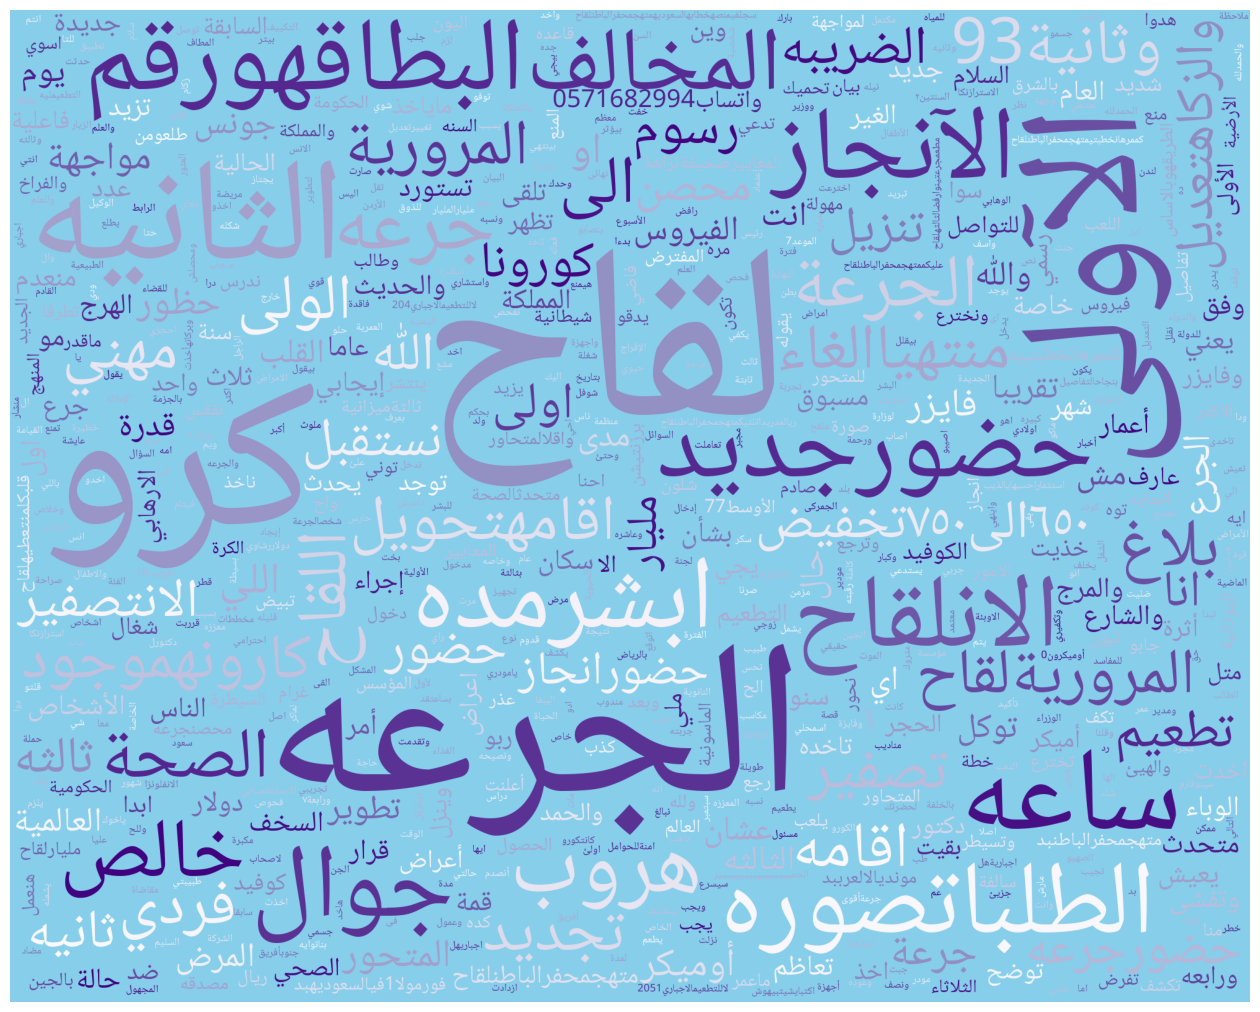

In [16]:
awc = ArabicWordCloud(width=2000,height=1600,max_font_size=400,max_words=10000,collocations=False, background_color='skyblue', colormap="Purples")
plt.figure(figsize=(16,16))
wc_ar = awc.from_text(u''.join(processedtext_ar2))
plt.axis("off")
plt.imshow(wc_ar)
plt.savefig("WC2.png")

In [20]:

did = DialectIdentifier.pretrained()

sentences = [
    'شنو عادي غدد تدمورنها منصجكم قاعدين تلعبون بارواح الناس من لقاح قاعدين تجربونه ع الشعب وعادي ليش ماتاخذونه وتجربونه عليكم و جريمة',
    'وحضرة اللفندي ده واخد انهي لقاح؟'
]

predictions = did.predict(sentences, 'city')
#print(predictions[0].top)
#print([p.top for p in predictions])

predictions = did.predict(sentences, 'country')
#print([p.top for p in predictions])

predictions = did.predict(sentences, 'region')
#print([p.top for p in predictions])

/Users/nada/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.23.2 when using version 1.2.2. This might lead to breaking code or

In [48]:

 
did = DialectIdentifier.pretrained()
sa = SentimentAnalyzer.pretrained()

import random

sen = []
for i in range(1,300):
    text =  processedtext_ar1[ random.randrange(len(processedtext_ar1)) ]
    sen.append( [sa.predict(text)[0], did.predict(text, 'city')[0].top, did.predict(text, 'country')[0].top, did.predict(text, 'region')[0].top, text ])
    time.sleep(.000005)


    
# for text in processedtext_ar1[:10]:
#         sen.append( [sa.predict(text)[0], did.predict(text, 'city')[0].top, did.predict(text, 'country')[0].top, did.predict(text, 'region')[0].top, text ])
#         time.sleep(.000005)

raw_df = pd.DataFrame(sen)

raw_df
import csv

with open('../Vaccine_in_Arab_World/tweets_plus_sentiments1.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(sen)

/Users/nada/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.23.2 when using version 1.2.2. This might lead to breaking code or

In [125]:
sen1 = []
nums = [10009, 13105, 14064, 16699, 16787, 1691, 16915, 17610, 17611 ]
for i in range(16914,len(processedtext_ar1)):
    if i in nums:
        continue
    text = processedtext_ar1[ i ]
    sen1.append([sa.predict(text)[0], did.predict(text, 'city')[0].top, did.predict(text, 'country')[0].top, did.predict(text, 'region')[0].top])
   

In [126]:
sentiments1 = pd.DataFrame( sen1, columns = ['sentiment', 'city', 'country', 'region' ] )
sentiments1
#sentiments1.to_csv('../Mapping/sentiments1_0_16908_to_18260.csv')


#sentiments1.city.value_counts().plot(kind = 'bar')

,sentiment,city,country,region
0,negative,Riyadh,Saudi Arabia,Gulf
1,neutral,Riyadh,Saudi Arabia,Gulf
2,negative,Riyadh,Saudi Arabia,Gulf
3,neutral,Salt,Jordan,Levant
4,neutral,Riyadh,Saudi Arabia,Gulf
...,...,...,...,...
1347,negative,Riyadh,Saudi Arabia,Gulf
1348,negative,Riyadh,Saudi Arabia,Gulf
1349,neutral,Riyadh,Saudi Arabia,Gulf
1350,negative,Riyadh,Saudi Arabia,Gulf


In [127]:
df1_all = pd.concat( [ sentiments1, pd.read_csv('../Vaccine_in_Arab_World/sentiments1_0_to_16908.csv') ] )
df1_all.to_csv('../Mapping/sentiments1.csv')
df1_all

,sentiment,city,country,region,Unnamed: 0
0,negative,Riyadh,Saudi Arabia,Gulf,NaN
1,neutral,Riyadh,Saudi Arabia,Gulf,NaN
2,negative,Riyadh,Saudi Arabia,Gulf,NaN
3,neutral,Salt,Jordan,Levant,NaN
4,neutral,Riyadh,Saudi Arabia,Gulf,NaN
...,...,...,...,...,...
16903,neutral,Salt,Jordan,Levant,16903.0
16904,neutral,Riyadh,Saudi Arabia,Gulf,16904.0
16905,neutral,Khartoum,Sudan,Nile Basin,16905.0
16906,neutral,Riyadh,Saudi Arabia,Gulf,16906.0


df_all

In [128]:

did = DialectIdentifier.pretrained()
sa = SentimentAnalyzer.pretrained()


/Users/nada/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.23.2 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.23.2 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/nada/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator FeatureUnion from version 0.23.2 when using version 0.23.0. This migh

In [53]:
sen2 = []

nums = [ 609, 2326, 2327, 2955, 2956, 4523, 4524, 4525,7187,7858, 8795, 
         10871, 12531, 12532, 16521, 18575, 24564, 33337, 36830 ]
for i in range(36827,len(processedtext_ar2)):
    if i in nums:
        continue
    text = processedtext_ar2[ i ]
    sen2.append([sa.predict(text)[0], did.predict(text, 'city')[0].top, did.predict(text, 'country')[0].top, did.predict(text, 'region')[0].top])
   


In [54]:
sentiments2 = pd.DataFrame( sen2, columns = ['sentiment', 'city', 'country', 'region' ] )
sentiments2
#sentiments2.to_csv('../Mapping/sentiments2_36829_to_42337.csv')



,sentiment,city,country,region


In [55]:
df2_all = pd.concat( [  sentiments2,
                        pd.read_csv('../Vaccine_in_Arab_World/sentiments2__upto_rec_24548.csv') ,
                        pd.read_csv('../Vaccine_in_Arab_World/sentiments2_33336_to_36829.csv') ,
                        pd.read_csv('../Vaccine_in_Arab_World/sentiments2_36829_to_42337.csv') ] )

In [56]:
df2_all
#df2_all.to_csv('../Mapping/sentiments2.csv')

,sentiment,city,country,region,Unnamed: 0
0,negative,Salt,Jordan,Levant,0
1,neutral,Riyadh,Saudi Arabia,Gulf,1
2,neutral,Amman,Syria,Levant,2
3,neutral,Riyadh,Saudi Arabia,Gulf,3
4,negative,Salt,Jordan,Levant,4
...,...,...,...,...,...
5503,positive,Riyadh,Saudi Arabia,Gulf,5503
5504,neutral,Salt,Saudi Arabia,Gulf,5504
5505,positive,Riyadh,Saudi Arabia,Gulf,5505
5506,neutral,Riyadh,Saudi Arabia,Gulf,5506


In [129]:
sentiments1 = pd.read_csv('../Vaccine_in_Arab_World/sentiments1.csv')
sentiments1

# sentiments2 = pd.read_csv('../Vaccine_in_Arab_World/sentiments2.csv')

,Unnamed: 0.1,sentiment,city,country,region,Unnamed: 0
0,0,negative,Riyadh,Saudi Arabia,Gulf,NaN
1,1,neutral,Riyadh,Saudi Arabia,Gulf,NaN
2,2,negative,Riyadh,Saudi Arabia,Gulf,NaN
3,3,neutral,Salt,Jordan,Levant,NaN
4,4,neutral,Riyadh,Saudi Arabia,Gulf,NaN
...,...,...,...,...,...,...
18255,16903,neutral,Salt,Jordan,Levant,16903.0
18256,16904,neutral,Riyadh,Saudi Arabia,Gulf,16904.0
18257,16905,neutral,Khartoum,Sudan,Nile Basin,16905.0
18258,16906,neutral,Riyadh,Saudi Arabia,Gulf,16906.0


In [133]:

titles = ['sentiment', 'city', 'country', 'region'] 
sentiment_type = ['positive', 'negative', 'neutral'] 

def build_matrix(sentiments):
    matrix = {}

    for row in sentiments.values.astype(str).tolist():
        if not matrix.get(row[0]):
            matrix[ row[0] ] = {}

        if not matrix[ row[0] ].get( row[1] ) :
            matrix[ row[0] ] [ row[1] ] = {}
            matrix[ row[0] ] [ row[1] ] = 1      
        else:
            matrix[ row[0] ] [ row[1] ] += 1      
            
    #pp.pprint(matrix )
    return(matrix)

In [227]:
# Creating a data frame using pandas to compare the occurrence of each word across all three sentiments
df1 = pd.DataFrame( build_matrix( sentiments1 ))


ax= df1.plot.bar(color = ('#FF8C00', '#228B22','#1E90FF' ), figsize=(20, 10))
#ax= df1.plot.bar(color = ('#FF8C00', '#228B22','#1E90FF' ))
ax.set_xlabel('Cities', fontsize=30)
ax.set_ylabel('Frequency', fontsize=30)
plt.xticks(fontsize=16)
plt.legend(fontsize = 20)

#df_sorted = df.sort_values(sentiments1.value_counts())
#plt.bar('Cities', 'Frequency', data=df_sorted)
#plt.savefig("sentiment_by_city1.png")

plt.show()



/Users/nada/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 1192x490472 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1440x720 with 1 Axes>

In [60]:
df2 = pd.DataFrame( build_matrix( sentiments2 ))

df2
# order = ['negative', 'neutral', 'positive']
ax= df2.plot.bar(color = ('#1E90FF','#228B22','#FF8C00'), figsize=(20, 10))
ax.set_xlabel('Cities', fontsize=30)
ax.set_ylabel('Frequency', fontsize=30)
plt.xticks(fontsize=16)
plt.legend(fontsize = 20)

plt.savefig("sentiment_by_city2.png")

plt.show()

{}


TypeError: no numeric data to plot

In [135]:
words = dict()
for i in range(0,len(processedtext_ar1)):
    for word in processedtext_ar1[i].split(' '):
        if  not words.get(''.join(reversed(word))):
            words[ u''.join(reversed(word)) ] = 1
        else:
            words[ u''.join(reversed(word)) ] += 1
words

{'بيلح': 7,
 'تيوكلا': 179,
 'عابني': 1,
 'رصمب': 61,
 'هرقباي': 1,
 'لاعت': 27,
 'رصم': 486,
 'كقرغب': 1,
 'روجأماي': 1,
 'يفاحاي': 1,
 'هقراح': 1,
 'مكمد': 1,
 'هرم': 116,
 'بيرهت': 1,
 'حاقل': 15031,
 'هرملاهو': 2,
 'هللو': 50,
 'دمحلا': 126,
 'همعنب': 1,
 'رودلا': 17,
 'يللا': 931,
 'قاب': 1,
 'تارايلم': 1,
 'تراصو': 17,
 'حئاضف': 1,
 'هرخسم': 2,
 'ملاعلاب': 23,
 '': 18269,
 'حاقلوكامينورتكلاناحتماوكام': 45,
 'لئاوعةمالسلينورتكلا': 2,
 'حاقلوكامينورتكلاناحتماوكامحاقلوكامينورتكلاناحتماوكامحاقلوكامينورتكلاناحتماوكامحاقلوكامينورتكلاناحتماوكامحاقلوكامينورتكلاناحتماوكامحاقلوكامينورتكلاناحتماوكامحاقلوكامينورتكلاناحتماوكام': 6,
 'ورتكلالاانسرداملثمنحتمنينورتكلاهداملاانسردملثمينورتكلانحتمنانقحينورتكلالا': 1,
 'يروضحلاناحتمألاىلعبالطربجيميلعتريزوتاعماجلابالطاوفصناحاقلوكامينورتكلاناحتماوكامانوربجييروضحلاىلعانوروكهورذيفهبلطلاهايحذاقناينورتكلالاناحتمالا': 1,
 'ابوروأ': 12,
 'دقتعت': 12,
 'اراكتحا': 1,
 'ءاكذلل': 1,
 'يلاتلابو': 10,
 'ضفرت': 33,
 'فارتعالا': 1,
 'مويلا': 430,
 'دعن': 2,
 'اوضع'

In [258]:
import googletrans
from googletrans import Translator

# new_vocab1 = Counter( counts )


clean_tweets = pd.DataFrame(list(words.keys()), columns=[ 'words'])

#print(clean_tweets.words[0:30])
clean_tweets.words[27]='عابني'
# wc_words = pd.DataFrame(clean_tweets.keys(),columns=['words'])
# wc_words
translator = Translator()

# wc = pd.DataFrame([ "هنا" ,"هناك" ], columns=['words'])
#print(clean_tweets.words[27],translator.translate( clean_tweets.words[27], dest = 'en', src = 'ar' )) 
wc = clean_tweets.words[0:10000].apply(lambda x: translator.translate(x, src='ar', dest='en').text )
#wc


ConnectTimeout: timed out

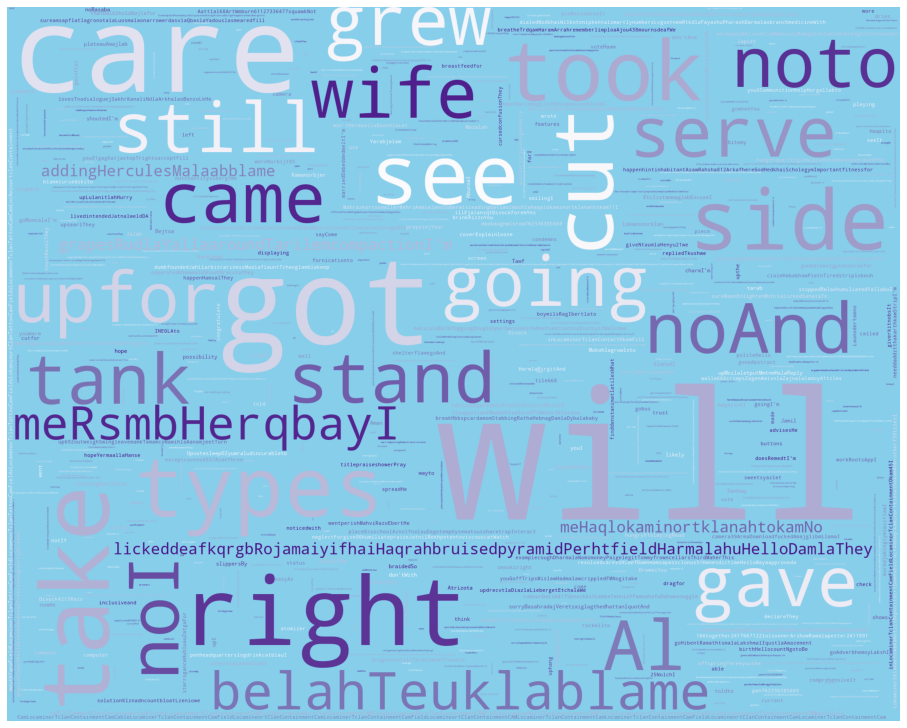

In [256]:

wc_en = WordCloud(width=2000,height=1600,max_font_size=400,max_words=10000,collocations=False, background_color='skyblue', colormap="Purples").generate(''.join(wc))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(wc_en)


# stopwords = set(STOPWORDS)
# #stopwords.update(['truetype', 'home','lebanon','volnteer', 'got', 'email', 'volunteer', 'video', 'let', 'contact','jne','may','pblic','member', 'story', 'abot','find', 'join','lebanese', 'minteshreen', 'national', 'bloc', 'party','donate', 'read', 'become', 'settings', 'site', 'cookie', 'browser', 'setting', 'monir', 'will', 'analytics', 'google', 'click', 'yor', 'website', 'cookies', 'measre', 'sorce', 'plugin', 'https', 'f', 'font', 'null', 'input', 'image', 'mmfidawla', 'aviacookierefused','searchaction', 'function', 'l', 't', 'a','of','the','is', 'an', 'it', 'm', 'by', 'this', 'in', 'on', 's', 'i', 'over', 'and', 'or', 'to'])
# df = pd.DataFrame(wc, index = vocabulary,columns = dicts.keys())



# wordcloud = WordCloud(width=1600, height=800, background_color='green', colormap="Reds", stopwords=stopwords).generate(word_bag[key][0])
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# print (key)
# plt.show()
# # awc = ArabicWordCloud(width=2000,height=1600,max_font_size=400,max_words=10000,collocations=False, background_color='skyblue', colormap="Purples")
# # plt.figure(figsize=(16,16))
# # wc_ar = awc.from_text(u''.join(processedtext_ar2))
# # plt.axis("off")
# # plt.imshow(wc_ar)



In [29]:
# def wordsToDictionary(word_bag):
#     word_freq = [word_bag.count(word) for word in word_bag]
#     return dict(list(zip(word_bag,word_freq)))

# #test_words = ["my","words","my","words","no","word","word","word"]
# for i in range(0,len(processedtext_ar1)):
#     for word in processedtext_ar1[i].split(' '):
#         test_words += word

# counted_words = wordsToDictionary(test_words)

# #print(counted_words)

# def sortDictionary(counted_words):
#     aux = [(counted_words[key], key) for key in counted_words]
#     aux.sort()
#     aux.reverse()
#     return aux

# counted_words = sortDictionary(counted_words)
# print(counted_words)


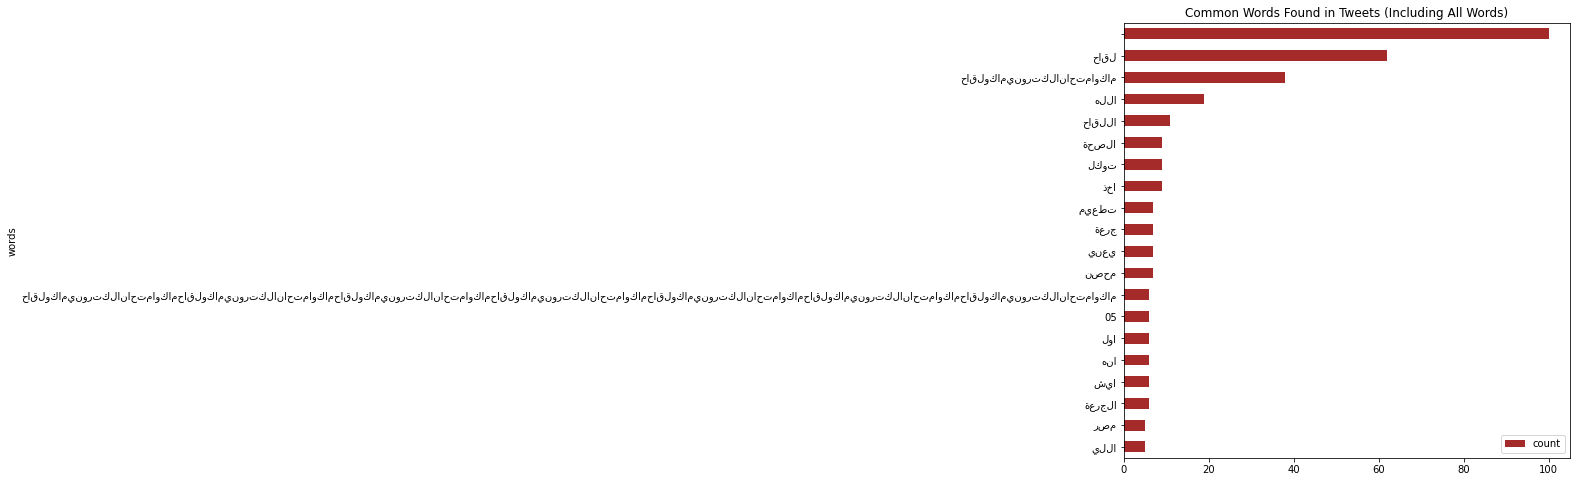

                                                words  count
0                                                        100
1                                                حاقل     62
2                          حاقلوكامينورتكلاناحتماوكام     38
3                                                هللا     19
4                                              حاقللا     11
5                                               ةحصلا      9
6                                                لكوت      9
7                                                 ذخا      9
8                                               ميعطت      7
9                                                ةعرج      7
10                                               ينعي      7
11                                               نصحم      7
12  حاقلوكامينورتكلاناحتماوكامحاقلوكامينورتكلاناحت...      6
13                                                 05      6
14                                                لوا      6
15                      

In [96]:
new_vocab1 = Counter( words )

fig, ax = plt.subplots(figsize=(8, 8))
#print(new_vocab)
clean_tweets = pd.DataFrame(new_vocab1.most_common(20), columns=['words', 'count'])
clean_tweets.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="brown")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()
print( clean_tweets)

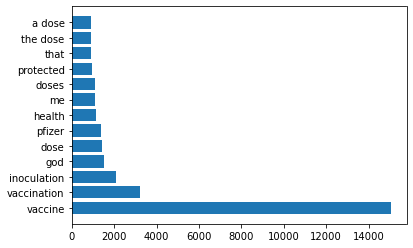

In [88]:
my_dict1= {u'vaccine':15031, u'vaccination': 3217, u'inoculation':2102, u'god':1520, u'dose': 1448, u'pfizer': 1389, u'health': 1168, u'me':1108, u'doses': 1106, u'protected': 935, u'that':931, u'the dose': 913, u'a dose':897   }

# plt.barh(range(len(my_dict1)), list(my_dict1.values()), align='center')
# plt.xticks(range(len(my_dict1)), list(my_dict1.keys()))
plt.barh(*zip(*my_dict1.items()))
plt.savefig("most_common_words1.png")
plt.show()


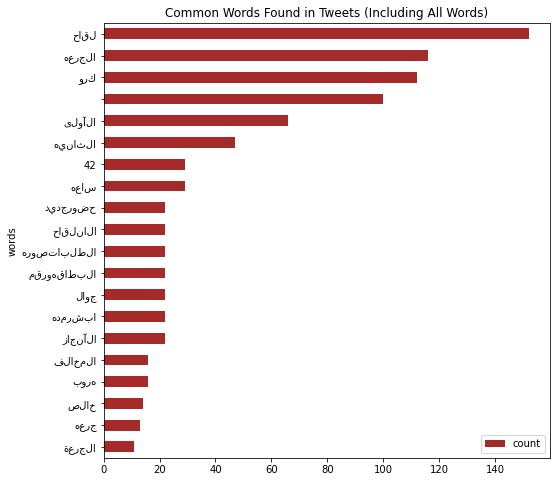

In [154]:
words = dict()
for i in range(0,len(processedtext_ar2)):
    for word in processedtext_ar2[i].split(' ') :
        if  not words.get(''.join(reversed(word))):
            words[ ''.join(reversed(word)) ] = 1
        else:
            words[ ''.join(reversed(word)) ] += 1

new_vocab2 = Counter( words )

# index = len(word)
# for j in range (0, len(word)):
#                 counts = word [ index - 1 ]   
        
        
        
fig, ax = plt.subplots(figsize=(8, 8))
#print(new_vocab)
clean_tweets = pd.DataFrame(new_vocab2.most_common(20), columns=['words', 'count'])
clean_tweets.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="brown")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()
#print(clean_tweets)


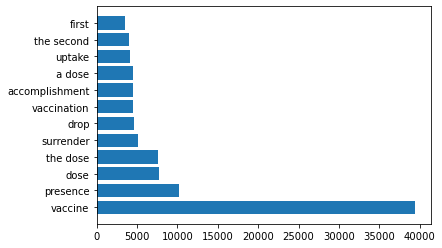

In [74]:
my_dict2= {u'vaccine':39470, u'presence': 10241, u'dose':7687, u'the dose':7610, u'surrender': 5067, u'drop': 4577, u'vaccination': 4543, u'accomplishment':4532, u' a dose': 4505, u'uptake':4169, u'the second': 4035, u'first':3484   }

plt.barh(*zip(*my_dict2.items()))
plt.savefig("most_common_words2.png")
plt.show()

In [30]:
print(df1)



sentiment_counts = (df1['positive'].sum(), df1['negative'].sum(), df1['neutral'].sum())
labels=["Positive","Negative", "Neutral"]
#colors=["#ff9999","#99ff99"]
#explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(sentiment_counts, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90 )
ax1.axis('equal')  
plt.tight_layout()
plt.title('Sentiment Distribution for Pre-Omicron Dataset')
plt.savefig("sentiment1.png")
plt.show()


            0    1    2    3    4    5    6    7    8    9  ...  16898  16899  \
negative  2.0  NaN  1.0  NaN  NaN  1.0  NaN  1.0  NaN  NaN  ...    1.0    NaN   
neutral   NaN  2.0  NaN  2.0  2.0  1.0  2.0  1.0  1.0  1.0  ...    NaN    1.0   
positive  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  1.0  1.0  ...    NaN    NaN   

          16900  16901  16902  16903  16904  16905  16906  16907  
negative    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
neutral     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  
positive    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[3 rows x 16908 columns]


KeyError: 'positive'

In [39]:
sentiment_counts = (df2['positive'].sum(), df2['negative'].sum(), df2['neutral'].sum())
labels=["Positive","Negative", "Neutral"]
#colors=["#ff9999","#99ff99"]
#explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(sentiment_counts, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title('Sentiment Distribution for Post-Omicron Dataset')
plt.savefig("sentiment2.png")
plt.show()

KeyError: 'positive'

In [204]:
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk import word_tokenize
import pandas as pd
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import googletrans
from googletrans import Translator

# new_vocab1 = Counter( counts )


# clean_tweets_1 = pd.DataFrame(new_vocab1, columns=['words', 'count'])
clean_tweets.words

# wc_words = pd.DataFrame(clean_tweets.keys(),columns=['words'])
# wc_words
# translator = Translator()

# wc = pd.DataFrame([ "هنا" ,"هناك" ], columns=['words'])
# #print( translator.translate( wc, dest = 'en', src = 'ar' ) )
wc = clean_tweets.apply(lambda x: translator.translate(x, src='ar', dest='en').text )
# wc

# wc_words['English'] = wc_words['words'].apply(translator.translate, src='ar', dest='en').apply(getattr, args=('text',))
# wc_words = wc_words.words.apply(lambda x: translator.translate(x, src='ar', dest='en').text )
# wc_words

# # wordcloud = WordCloud(width=2000,height=1600,max_font_size=400,max_words=10000,collocations=False, background_color='skyblue', colormap="Purples").generate
# #plt.imshow(wordcloud, interpolation='bilinear')
# plt.figure(figsize=(16,16))
# wc1 = wordcloud(wc_words)
# plt.axis("off")
# plt.imshow(wc1)



ValueError: ('Lengths must match to compare', (20,), (1, 0))